In [1]:
import cv2
import numpy as np
import random
import os, sys, glob, pickle
from xml.dom import minidom
import matplotlib.path as mplPath
import numpy as np
#import openslide
import time
import pdb
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F

from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [3]:
# resnet50 = models.resnet50(pretrained=True).to(device)

In [4]:
MODEL_PATH = '_ckpt_epoch_9.ckpt'
RETURN_PREACTIVATION = True  # return features from the model, if false return classification logits
NUM_CLASSES = 4  # only used if RETURN_PREACTIVATION = False


def load_model_weights(model, weights):

    model_dict = model.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    model.load_state_dict(model_dict)

    return model


model = models.__dict__['resnet18'](pretrained=False)

state = torch.load(MODEL_PATH, map_location=device)

state_dict = state['state_dict']
for key in list(state_dict.keys()):
    state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

model = load_model_weights(model, state_dict)

if RETURN_PREACTIVATION:
    model.fc = torch.nn.Sequential()
else:
    model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

model = model.cuda()

In [3]:
MODEL_PATH = 'tenpercent_resnet18.ckpt'
RETURN_PREACTIVATION = True  # return features from the model, if false return classification logits
NUM_CLASSES = 4  # only used if RETURN_PREACTIVATION = False


def load_model_weights(model, weights):

    model_dict = model.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    model.load_state_dict(model_dict)

    return model


model = models.__dict__['resnet18'](pretrained=False)

state = torch.load(MODEL_PATH, map_location=device)

state_dict = state['state_dict']
for key in list(state_dict.keys()):
    state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

model = load_model_weights(model, state_dict)

if RETURN_PREACTIVATION:
    model.fc = torch.nn.Sequential()
else:
    model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

model = model.cuda()

In [4]:
class SiameseNetwork(nn.Module):
    def __init__(self, model):
        super(SiameseNetwork, self).__init__()
        self.model = model
    
    def forward_once(self, x):
        out = self.model(x)
        return out
    
    def forward(self, x1, x2):
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        return out1, out2

In [5]:
class SiamDataset(Dataset):
    def __init__(self, img_file_list, mode='load', affine_param=5, jitter_param=0.4, detailed=False):
        self.img_file_list = img_file_list
        self.detailed = detailed
        self.randomCrop = torchvision.transforms.RandomCrop(224)
        
        self.mode = mode
        if mode=='create':
            self.single_transform = torchvision.transforms.Compose([
                torchvision.transforms.RandomCrop(224),
                torchvision.transforms.ToTensor()
            ])
            self.augment = torchvision.transforms.Compose([
                torchvision.transforms.ToPILImage(),
                torchvision.transforms.RandomHorizontalFlip(),
                torchvision.transforms.RandomAffine(affine_param),
                torchvision.transforms.ColorJitter(
                    brightness=jitter_param,
                    contrast=jitter_param,
                    saturation=jitter_param),
                torchvision.transforms.ToTensor()
            ])

            self.wsi_list = []
            self.wsi_weight = []
            for img_file in img_file_list:
                wsi = Image.open(img_file).convert('RGB')
                self.wsi_list.append(wsi)
                h,w = wsi.size
                self.wsi_weight.append(h*w)
            
            
            
        
    def sample(self):
        wsi = random.choices(self.wsi_list, weights=self.wsi_weight)[0]

        img = self.single_transform(wsi)
        
        return img
    
    
    def sample_detailed(self):
        wsi = random.choices(self.wsi_list, weights=self.wsi_weight)[0]
        wsi_idx = self.wsi_list.index(wsi)
        
        i,j,h,w = self.randomCrop.get_params(wsi, self.randomCrop.size)
        
        return wsi_idx, i,j, F.crop(wsi, i,j,h,w)
               
        
    def __getitem__(self, index):
        if self.mode=='create':
            img1 = self.sample()

            augment = np.random.binomial(1,0.5)

            img2 = self.augment(img1) if augment else self.sample()
        else:
            pkl = open(self.img_file_list[index], "rb")
            img1, img2, augment = pickle.load(pkl)
            pkl.close()
        
        return [img1, img2, augment]
        
        
        
    def __len__(self):
        if self.mode=='create':
            acc = 0
            for wsi in self.wsi_list:
                h,w = wsi.size
                acc += 1.*h*w/(224*224)
            return int(acc)
        
        return len(self.img_file_list)

In [6]:
def create_dataset():
    img_file_list = glob.glob("/home/Drive3/Karman/TCGA_dataset/TCGA-A1-A0SD-01Z-00-DX1.DB17BFA9-D951-42A8-91D2-F4C2EBC6EB9F/*.png")
    dataset = SiamDataset(img_file_list, mode='create')

    out_file_path = "data/tcga_"
    if not os.path.exists(out_file_path):
        os.makedirs(out_file_path)

    torch.manual_seed(77077)
    random.seed(71017)

    idx=0
    for data in dataset:
        pickle_out = open(out_file_path+str(idx),"wb")
        pickle.dump(data, pickle_out)
        pickle_out.close()
        idx += 1
        if idx>=len(dataset):
            break

#create_dataset()

In [7]:
class ContrastiveLoss(nn.Module):
    # label == 1 means same sample, label == 0 means different samples
    def __init__(self, margin=0., do_average=True):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = 1e-6
        self.relu = nn.ReLU()
        self.do_average = do_average
    
    def forward(self, out1, out2, labels):
        dist = (out1 - out2).pow(2).sum(1)
        loss = 0.5*(labels*dist + 
                   (1 + -1.*labels)*self.relu(self.margin - (dist+self.eps).sqrt()).pow(2))
        return loss.mean() if self.do_average else loss.sum()

In [8]:
def train(args, model, device, loss_fn, train_loader, optimizer, num_epochs):
    
    
    for epoch in range(num_epochs): 
        epoch_loss = 0.
        for batch_idx, data in enumerate(train_loader):
            x1 = data[0].to(device)
            x2 = data[1].to(device)
            label = data[2].to(device)

            optimizer.zero_grad()

            model.train()

            out1, out2 = model(x1, x2)

            loss = loss_fn(out1, out2, label) # calculates the loss
            curr_loss = loss.item()
            loss.backward()
            optimizer.step()
            epoch_loss += curr_loss
            
            del x1
            del x2
            del label
            
            if batch_idx % args['log_interval'] == 0 :
                print('Train Epoch: {} [({:.0f}%)]\tLoss: {:.4f}'.format(
                    epoch, 100. * (batch_idx+1) / len(train_loader), curr_loss))
            if batch_idx+1 == len(train_loader):
                print('\nEpoch: {} Total Loss: {:.4f}\n'.format(epoch, epoch_loss))

In [9]:
args = {}
args['batch_size'] = 150
args['epochs'] = 50
args['seed']=990077
args['lr']=0.01
args['train_ratio']=0.8
args['log_interval']=8

torch.manual_seed(args['seed'])

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

In [10]:
siamNetwork = SiameseNetwork(model)

data_file_list = sorted(glob.glob("data/*"))
dataset = SiamDataset(data_file_list)

train_loader = DataLoader(dataset=dataset, batch_size=args['batch_size'], shuffle = True, **kwargs)

loss_fn = ContrastiveLoss(do_average=False)

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])

In [18]:
train(args, siamNetwork, device, loss_fn, train_loader, optimizer, args['epochs'])

KeyboardInterrupt: 

In [13]:
torch.save({
    'epoch': args['epochs'],
    'model_state_dict': siamNetwork.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    }, 'checkpoints/siamese_3epoch_1wsi_lossSum.pth.tar')

In [61]:
checkpoint = torch.load('checkpoints/siamese_3epoch_1wsi_lossSum.pth.tar')
args['epochs'] = checkpoint['epoch']
siamNetwork.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [11]:
from sklearn import manifold
from mpl_toolkits.mplot3d import Axes3D
from time import time
from matplotlib.ticker import NullFormatter
import matplotlib.pyplot as plt
%matplotlib inline

# Next line to silence pyflakes. This import is needed.
Axes3D



mpl_toolkits.mplot3d.axes3d.Axes3D

In [12]:
# get 2000 images embedded for tsne
img_file_list = glob.glob("/home/Drive3/Karman/TCGA_dataset/TCGA-A1-A0SD-01Z-00-DX1.DB17BFA9-D951-42A8-91D2-F4C2EBC6EB9F/*.png")
dataset = SiamDataset(img_file_list, mode='create', detailed=True)

In [13]:
from kmeans_pytorch import kmeans

torch.manual_seed(90515)
random.seed(88054)


count = 0
num_samples = 2000
wsi_idx_list = [0]*num_samples
pt_list = np.zeros([num_samples,2])
sample_size = 512

x_cluster = torch.Tensor(num_samples, sample_size)
# print(x_cluster)
# torch.cat(data_arr, dim=0, out=x_cluster)
# #torch.cat(data_arr, dim=0)
# print(x_cluster.shape)


siamNetwork.eval()

with torch.no_grad():
    for idx in range(num_samples):
        wsi_idx, i,j, img = dataset.sample_detailed()
        wsi_idx_list[idx] = wsi_idx
        pt_list[idx,:] = i,j 
        x_cluster[idx,:] = siamNetwork.forward_once(img.unsqueeze(dim=0).to(device))
        del img




num_clusters = 5

t0 = time()
cluster_ids_x, cluster_centers = kmeans(
    X=x_cluster, num_clusters=num_clusters, distance='euclidean', device=torch.device('cuda:0')
)
t1 = time()
print("%s: %.2g sec" % ("time", t1 - t0))


[running kmeans]: 0it [00:00, ?it/s]/home/shrey/.conda/envs/py37/lib/python3.7/site-packages/kmeans_pytorch/__init__.py:63: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  selected = torch.nonzero(choice_cluster == index).squeeze().to(device)
[running kmeans]: 9it [00:00,  9.55it/s, center_shift=0.085261, iteration=10, tol=0.000100] 

running k-means on cuda:0..


[running kmeans]: 32it [00:00, 81.12it/s, center_shift=0.000000, iteration=33, tol=0.000100]

time: 0.41 sec


In [14]:
x_cluster[0,:]

tensor([1.3781e-01, 7.6303e-02, 0.0000e+00, 1.7983e-01, 2.3324e-01, 1.0005e+00,
        3.4917e-02, 6.7150e-02, 3.3841e-01, 3.4023e-01, 7.5580e-03, 4.3655e-01,
        2.3015e-03, 6.8517e-02, 5.5778e-01, 3.7185e-01, 1.2679e-01, 9.6775e-01,
        4.3520e-01, 1.8061e-01, 7.2678e-02, 0.0000e+00, 2.6901e-01, 1.3074e-01,
        3.1888e-01, 8.4583e-03, 7.9197e-01, 5.5531e-02, 0.0000e+00, 8.1898e-02,
        5.1418e-02, 1.9162e-01, 1.1145e+00, 1.1975e-02, 4.5592e-01, 4.7768e-02,
        5.5515e-01, 1.9726e-01, 5.5710e-02, 3.4494e-01, 7.3024e-02, 1.9776e-01,
        7.0447e-01, 1.3577e-01, 6.7199e-02, 1.4013e-01, 3.4603e-02, 5.1206e-01,
        1.1698e-01, 8.4848e-01, 1.9210e-01, 6.5397e-01, 1.2098e-01, 3.3945e-01,
        9.2562e-02, 3.2870e-01, 3.6003e-01, 4.2704e-02, 2.2543e-01, 1.3353e-01,
        3.2144e-03, 1.8605e-03, 5.8400e-02, 2.1201e-02, 3.4873e-01, 2.9126e-01,
        1.9976e-01, 1.7511e-02, 4.4369e-01, 1.0328e-01, 8.3570e-02, 2.7746e-01,
        4.3008e-01, 2.1204e-01, 2.0182e-

In [15]:
print(type(x_cluster))
print(x_cluster.shape)

X = x_cluster.numpy()

print(type(X))
print(X.shape)

<class 'torch.Tensor'>
torch.Size([2000, 512])
<class 'numpy.ndarray'>
(2000, 512)


In [16]:
# x = data_arr
# x = np.asarray([i.cpu().numpy() for i in x])
# X = x.squeeze()

X = x_cluster.numpy()

# n_components = X.shape[-1]
n_components = 2

method = manifold.TSNE(n_components=n_components, init='pca', random_state=79)


[running kmeans]: 33it [00:00, 68.96it/s, center_shift=0.000000, iteration=33, tol=0.000100]


time: 8.7 sec


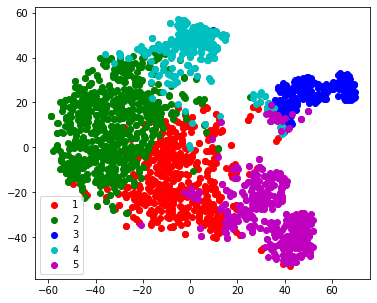

In [17]:
# # Create figure
# fig = plt.figure()

# # Add 3d scatter plot
# ax = fig.add_subplot(251, projection='3d')
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], cmap=plt.cm.Spectral)
# ax.view_init(4, -72)

t0 = time()
Y = method.fit_transform(X)
t1 = time()
print("%s: %.2g sec" % ("time", t1 - t0))
# # ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
# ax.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
# ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
# ax.axis('tight')

# plt.show()




plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm'#, 'y', 'k', 'w', 'orange', 'purple'
labels = ['1', '2', '3', '4', '5']
for i in range(num_clusters):
    plt.scatter(Y[cluster_ids_x==i, 0], Y[cluster_ids_x==i, 1], c=colors[i], label=labels[i])
plt.legend()
plt.show()

tensor([[2.8026e-45],
        [0.0000e+00],
        [1.2920e-17],
        ...,
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00]])
torch.Size([2000, 512])
running k-means on cuda:0..


RuntimeError: CUDA error: an illegal memory access was encountered

In [22]:
del data_arr